In [1]:
from unrealcv import client
import unrealcv
from tqdm import tqdm

print(unrealcv.__version__)


=> Info: Use inet client...
1.0.0


INFO:__init__:234:Got connection confirm: b'connected to MyProject'


=>Info: using ip-port socket
start
end1
-1057.377 -1407.484 228.395
0.000 0.000 0.000


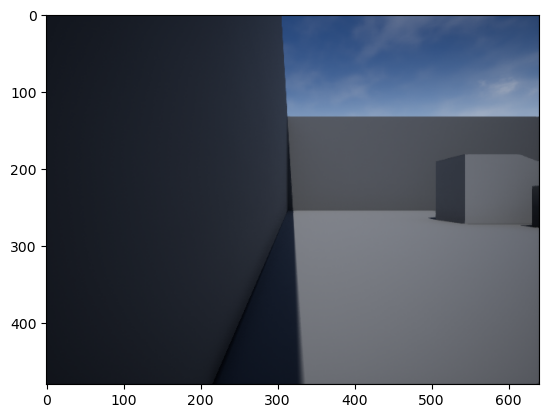

In [2]:
import cv2
import numpy as np
from unrealcv.util import read_png, read_npy
from unrealcv.automation import UE4Binary
from unrealcv import client
import matplotlib.pyplot as plt
plt.ion()
%matplotlib inline
# Connect to the game
client.connect()

# Check if the client is connected
if not client.isconnected():
    print('UnrealCV server is not running. Run the game from http://unrealcv.github.io first.')
else:
    # Capture the current image from the virtual camera
    print("start")
    res = client.request('vget /camera/0/lit png')
    print("end1")
    img = read_png(res)
    plt.imshow(img)
    
    res = client.request('vget /camera/0/location')
    print(res)
    res = client.request('vget /camera/0/rotation')
    print(res)
    try:
        img = img.reshape((480, 640, 3))
    except ValueError:
        # resize image to target shape
        img = cv2.resize(img, (640, 480))

    # Display the captured image
    # cv2.imshow('UnrealCV Image', img)
    # cv2.waitKey(0)

In [3]:
import random
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.9  # discount rate
        self.epsilon = 0.96  # exploration rate
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.batch_size = 32  # 指定 batch size
    
    @tf.autograph.experimental.do_not_convert
    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=self.state_size))
        model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
        model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
        model.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = np.reshape(state, [1, *self.state_size])
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) >= self.batch_size:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                target = reward
                if not done:
                    # Calculate the target Q value
                    target = (reward + self.gamma * 
                            np.amax(self.model.predict(np.expand_dims(next_state, axis=0), verbose=0)[0]))
                # Get the target Q value for the current state
                target_f = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
                # Update the target Q value for the chosen action
                target_f[0][action] = target
                # Train the model on the current state and target Q value
                self.model.fit(np.expand_dims(state, axis=0), target_f, epochs=1, verbose=0)
            # Decrease epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def save(self, filename):
        self.model.save_weights(filename)

    def load(self, filename):
        self.model.load_weights(filename)

    # Define the state
    def get_state(self):
        # Capture the current image from the virtual camera
        res = client.request('vget /camera/0/lit png')
        img = read_png(res)

        # Resize image to target shape
        img = cv2.resize(img, (84, 84))

        # Convert image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Normalize the image
        img_norm = np.divide(img_gray, 255)

        # Add channel dimension
        img_final = np.expand_dims(img_norm, axis=2)

        return img_final


2.10.0


In [4]:
import tensorflow as tf
tf.__version__


'2.10.0'

In [5]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


TensorFlow version: 2.10.0
Num GPUs: 1


In [7]:
import os
import random 
import time

# 設定參數
step_record=[]
num_episodes = 2
max_steps_per_episode = 20000
# 定義函式以獲取物體的標籤
def get_obj_tags(obj_name):
    res = client.request(f'vget /object/{obj_name}/tags')
    return res.split(',')

# 更新攝影機位置
def update_camera_position(x, y, z):
    client.request(f'vset /camera/0/location {x} {y} {z}')

# 更新攝影機旋轉
def update_camera_rotation(pitch, yaw, roll):
    client.request(f'vset /camera/0/rotation {pitch} {yaw} {roll}')

# 獲取攝影機圖像
def get_camera_image():
    res = client.request('vget /camera/0/lit npy')
    current_pose = client.request('vget /camera/0/pose')
    x, y, z, pitch, yaw, roll = current_pose.split()
    return float(x), float(y), float(z), float(pitch), float(yaw), float(roll)

def calculate_reward(step_record, step):
    if not step_record:  # 如果step_record是空
        reward = 0
    else:
        average_step_record = sum(step_record) / len(step_record)
        reward = average_step_record - step

    return reward

# 定義狀態大小和行動大小
action = 4

# 定義DQNAgent
agent = DQNAgent(state_size=(480, 640, 4), action_size=action)


# 檢查是否使用GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# 如果存在且不為空，則加載權重
if os.path.isfile("model_weights.h5") and os.path.getsize("model_weights.h5") > 0:
    agent.load("model_weights.h5")
else:
    print("No weights file found or file is empty")
# 定義房間範圍
min_x = -780
max_x = 780
min_y = -20
max_y = 3520
min_z = 120.15


# 在GPU上運行計算
with tf.device('/GPU:0'):
    # 迴圈進行試驗
    for episode in tqdm(range(num_episodes)):
        # 重設試驗的環境
        client.request('vset /camera/0/location 536.087 -546.017 228.442')
        client.request('vset /camera/0/rotation 0 0 0')
        res = client.request('vget /camera/0/lit npy')
        state = read_npy(res)
        
        # 初始化試驗的總獎勵和步數計數器
        total_reward = 0
        step = 0

        # 迴圈進行步驟
        while True:
            # 根據當前狀態選擇行動
            action = agent.act(state)
            x, y, z, pitch, yaw, roll = get_camera_image()

            if action == 0:     # 向前移动
                client.request('vset /action/keyboard w 1')
        
            elif action == 1:   # 向后移动
                client.request('vset /action/keyboard s 1')
                # client.request('vset /camera/0/rotation 0 180 0')
                
            elif action == 2:   # 向左移动
                client.request('vset /action/keyboard a 1')
                # client.request('vset /camera/0/rotation 0 -90 0')
                
            elif action == 3:   # 向右移动
                client.request('vset /action/keyboard d 1')
                # client.request('vset /camera/0/rotation 0 90 0')

            # 觀察新的狀態
            res = client.request('vget /camera/0/lit npy')
            next_state = read_npy(res)

            # 設定獎勵為0，並且設定done為False，因為沒有可移動的物體
            reward = 0
            done = False

            # 檢查代理是否達到目標坐標
            target_positions = [(-407.301, 46.583, 228.418)]
            target_range = (20000/(len(step_record)+20))/2  # 設置目標範圍


            step += 1
            if step % 1 == 0:
                print(f"action: {action}, step: {step}" )
                
            #到達目的
            for target_pos in target_positions:
                target_x, target_y, target_z = target_pos
                if abs(x - target_x) <= target_range and abs(y - target_y) <= target_range and (z - target_z) >=0:
                # 如果代理到達目標坐標範圍內，設置done為True
                    done = True
                    reward += 2000
                    break
                    
            #到達最大步數
            if step == max_steps_per_episode :
                reward += -2000
            

            # 檢查試驗是否結束
            if done or (step == max_steps_per_episode) :
                reward += calculate_reward(step_record, step)
                # 記住經驗
                step_record.append(step)
                agent.remember(state, action, reward, next_state, done)
                agent.replay()
                # 儲存權重
                agent.save("model_weights.h5")
                break
            
            # 記住經驗
            agent.remember(state, action, reward, next_state, done)
            # 更新狀態
            state = next_state
            
        agent.replay()
         # 儲存權重
        agent.save("model_weights.h5")
        # 印出試驗的總獎勵
        print(f"Episode {episode+1} complete. reward: {reward}. step: {step}")
        
        
   


Num GPUs Available:  1
No weights file found or file is empty


  0%|          | 0/20 [00:00<?, ?it/s]

action: 3, step: 1
action: 1, step: 2
action: 2, step: 3
action: 1, step: 4
action: 0, step: 5
action: 1, step: 6
action: 2, step: 7
action: 2, step: 8
action: 2, step: 9
action: 3, step: 10
action: 2, step: 11
action: 3, step: 12
action: 2, step: 13
action: 3, step: 14
action: 2, step: 15
action: 3, step: 16
action: 3, step: 17
action: 3, step: 18
action: 3, step: 19
action: 1, step: 20
action: 1, step: 21
action: 2, step: 22
action: 2, step: 23
action: 1, step: 24
action: 0, step: 25
action: 1, step: 26
action: 1, step: 27
action: 3, step: 28
action: 0, step: 29
action: 1, step: 30
action: 0, step: 31
action: 0, step: 32
action: 1, step: 33
action: 1, step: 34
action: 2, step: 35
action: 2, step: 36
action: 3, step: 37
action: 2, step: 38
action: 1, step: 39
action: 0, step: 40
action: 1, step: 41
action: 3, step: 42
action: 1, step: 43
action: 2, step: 44
action: 1, step: 45
action: 1, step: 46
action: 1, step: 47
action: 0, step: 48
action: 2, step: 49
action: 3, step: 50
action: 0

  5%|▌         | 1/20 [04:56<1:33:57, 296.70s/it]

Episode 1 complete. reward: 2000. step: 3383
action: 2, step: 1
action: 0, step: 2
action: 1, step: 3
action: 3, step: 4
action: 0, step: 5
action: 0, step: 6
action: 3, step: 7
action: 2, step: 8
action: 2, step: 9
action: 3, step: 10
action: 3, step: 11
action: 0, step: 12
action: 1, step: 13
action: 2, step: 14
action: 0, step: 15
action: 0, step: 16
action: 0, step: 17
action: 0, step: 18
action: 2, step: 19
action: 2, step: 20
action: 3, step: 21
action: 0, step: 22
action: 0, step: 23
action: 3, step: 24
action: 0, step: 25
action: 2, step: 26
action: 0, step: 27
action: 0, step: 28
action: 2, step: 29
action: 0, step: 30
action: 0, step: 31
action: 0, step: 32
action: 1, step: 33
action: 0, step: 34
action: 0, step: 35
action: 2, step: 36
action: 2, step: 37
action: 2, step: 38
action: 1, step: 39
action: 0, step: 40
action: 2, step: 41
action: 2, step: 42
action: 1, step: 43
action: 1, step: 44
action: 0, step: 45
action: 2, step: 46
action: 0, step: 47
action: 1, step: 48
acti

 10%|█         | 2/20 [15:44<2:30:53, 502.96s/it]

Episode 2 complete. reward: -1165.0. step: 6548
action: 3, step: 1
action: 0, step: 2
action: 3, step: 3
action: 2, step: 4
action: 2, step: 5
action: 3, step: 6
action: 3, step: 7
action: 3, step: 8
action: 0, step: 9
action: 2, step: 10
action: 3, step: 11
action: 0, step: 12
action: 1, step: 13
action: 3, step: 14
action: 3, step: 15
action: 1, step: 16
action: 3, step: 17
action: 3, step: 18
action: 3, step: 19
action: 2, step: 20
action: 0, step: 21
action: 3, step: 22
action: 3, step: 23
action: 3, step: 24
action: 2, step: 25
action: 0, step: 26
action: 3, step: 27
action: 2, step: 28
action: 3, step: 29
action: 0, step: 30
action: 2, step: 31
action: 2, step: 32
action: 2, step: 33
action: 3, step: 34
action: 3, step: 35
action: 1, step: 36
action: 3, step: 37
action: 2, step: 38
action: 2, step: 39
action: 3, step: 40
action: 0, step: 41
action: 0, step: 42
action: 3, step: 43
action: 3, step: 44
action: 2, step: 45
action: 3, step: 46
action: 3, step: 47
action: 3, step: 48
a

 15%|█▌        | 3/20 [21:11<1:59:50, 422.97s/it]

Episode 3 complete. reward: 4434.5. step: 2531
action: 0, step: 1
action: 0, step: 2
action: 0, step: 3
action: 0, step: 4
action: 1, step: 5
action: 0, step: 6
action: 3, step: 7
action: 3, step: 8
action: 0, step: 9
action: 1, step: 10
action: 0, step: 11
action: 0, step: 12
action: 0, step: 13
action: 3, step: 14
action: 0, step: 15
action: 0, step: 16
action: 0, step: 17
action: 2, step: 18
action: 0, step: 19
action: 0, step: 20
action: 3, step: 21
action: 3, step: 22
action: 0, step: 23
action: 3, step: 24
action: 0, step: 25
action: 3, step: 26
action: 0, step: 27
action: 1, step: 28
action: 0, step: 29
action: 0, step: 30
action: 0, step: 31
action: 3, step: 32
action: 0, step: 33
action: 3, step: 34
action: 0, step: 35
action: 3, step: 36
action: 0, step: 37
action: 0, step: 38
action: 2, step: 39
action: 3, step: 40
action: 0, step: 41
action: 3, step: 42
action: 0, step: 43
action: 0, step: 44
action: 0, step: 45
action: 0, step: 46
action: 3, step: 47
action: 3, step: 48
ac

 15%|█▌        | 3/20 [48:00<4:32:01, 960.07s/it]


KeyboardInterrupt: 

In [ ]:
agent.model.summary()